In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from datetime import date
import yfinance as yfin
yfin.pdr_override()

In [4]:
df = pdr.get_data_yahoo("TSLA", start="2013-01-01", end=date.today())
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,2.333333,2.363333,2.314000,2.357333,2.357333,17922000
2013-01-03,2.345333,2.363333,2.316667,2.318000,2.318000,11130000
2013-01-04,2.320000,2.320000,2.261333,2.293333,2.293333,10110000
2013-01-07,2.320000,2.320000,2.260000,2.289333,2.289333,6630000
2013-01-08,2.300000,2.300000,2.207333,2.245333,2.245333,19260000


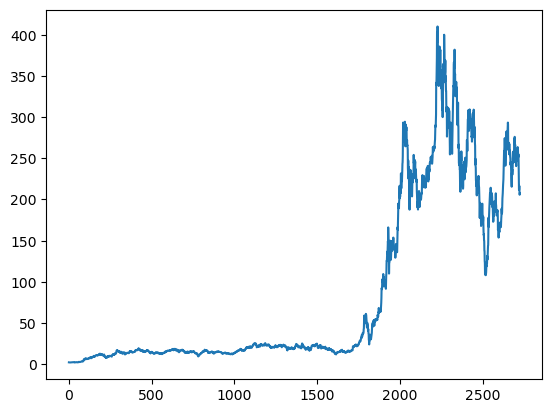

In [5]:
df = df.reset_index()
df = df.drop(['Date','Adj Close'],axis=1) 
plt.plot(df.Close)

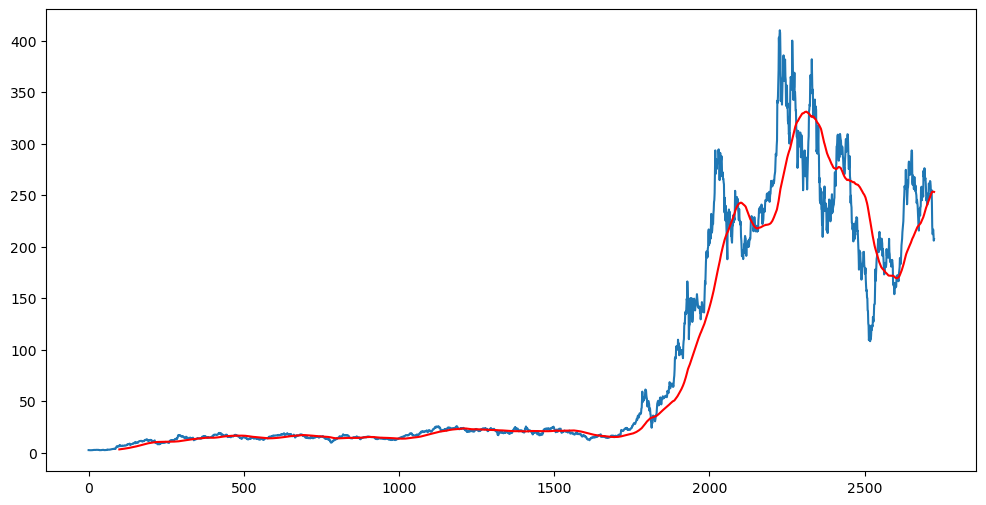

In [6]:
ma100 = df.Close.rolling(100).mean()
plt.figure(figsize= (12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')

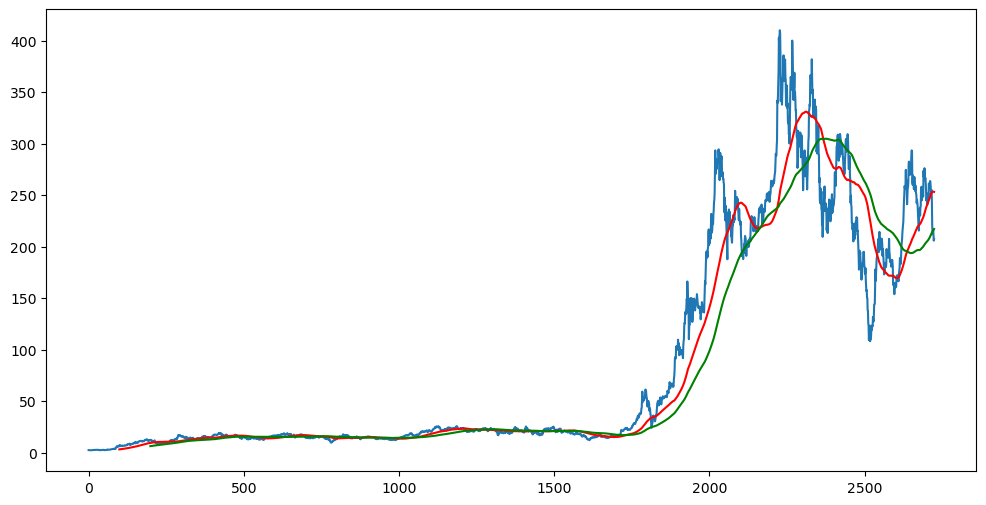

In [7]:
ma200 = df.Close.rolling(200).mean()
plt.figure(figsize= (12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')

In [8]:
train_data = pd.DataFrame(df['Close'][0:int(len(df)*0.70)])
test_data = pd.DataFrame(df['Close'][int(len(df)*0.70):int(len(df))])

scaler = MinMaxScaler(feature_range=(0,1))
train_data_arr = scaler.fit_transform(train_data)

In [9]:
x_train = []
y_train = []

for i in range(100, train_data_arr.shape[0]):
  x_train.append(train_data_arr[i-100:i])
  y_train.append(train_data_arr[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [11]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=50)

Epoch 1/50
57/57 [==============================] - 40s 400ms/step - loss: 0.0079
Epoch 2/50
57/57 [==============================] - 23s 402ms/step - loss: 0.0035
Epoch 3/50
57/57 [==============================] - 23s 406ms/step - loss: 0.0027
Epoch 4/50
57/57 [==============================] - 22s 385ms/step - loss: 0.0043
Epoch 5/50
57/57 [==============================] - 22s 391ms/step - loss: 0.0027
Epoch 6/50
57/57 [==============================] - 23s 404ms/step - loss: 0.0018
Epoch 7/50
57/57 [==============================] - 23s 404ms/step - loss: 0.0025
Epoch 8/50
57/57 [==============================] - 22s 388ms/step - loss: 0.0020
Epoch 9/50
57/57 [==============================] - 23s 398ms/step - loss: 0.0018
Epoch 10/50
57/57 [==============================] - 23s 402ms/step - loss: 0.0017
Epoch 11/50
57/57 [==============================] - 24s 415ms/step - loss: 0.0022
Epoch 12/50
57/57 [==============================] - 23s 398ms/step - loss: 0.0019
Epoch 13/50
5

In [12]:
model.save('keras_model.h5')

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
test_data.head()

,Close
1907,99.166000
1908,95.384003
1909,99.000000
1910,99.133331
1911,99.001335


In [14]:
past_100 = train_data.tail(100)
final_df = past_100.append(test_data, ignore_index=True)
input_data = scaler.fit_transform(final_df)
input_data.shape

C:\Users\HP\AppData\Local\Temp\ipykernel_15320\3139988074.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = past_100.append(test_data, ignore_index=True)


(918, 1)

In [15]:
x_test =[]
y_test = []

for i in range(100, input_data.shape[0]):
  x_test.append(input_data[i-100:i])
  y_test.append(input_data[i,0])

x_test, y_test = np.array(x_test), np.array(y_test)

In [16]:
y_pred = model.predict(x_test)
scaler.scale_

26/26 [==============================] - 5s 136ms/step


array([0.00259142])

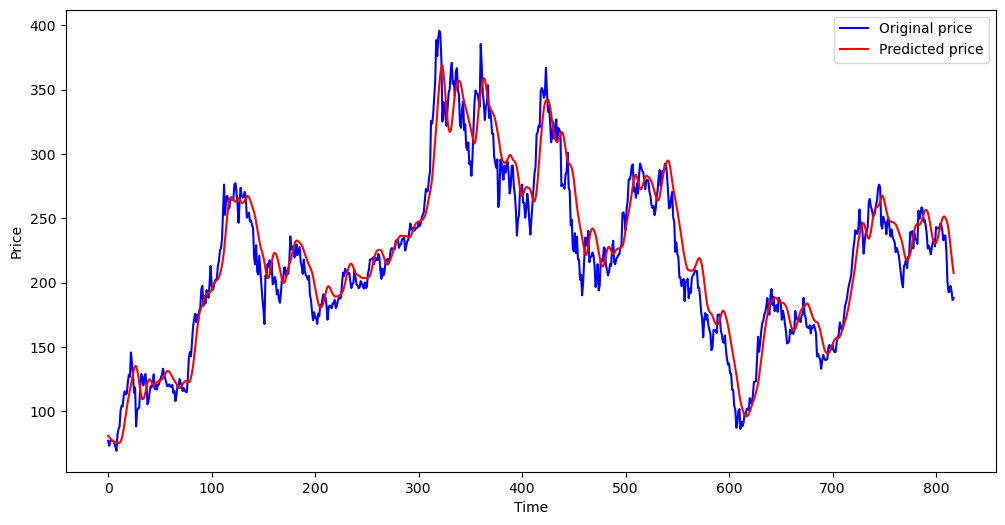

In [17]:
scale_factor = 1/0.00252604
y_pred = y_pred*scale_factor
y_test = y_test*scale_factor
plt.figure(figsize=(12,6))
plt.plot(y_test,'b', label="Original price")
plt.plot(y_pred,'r', label="Predicted price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()